In [1]:
import pandas as pd
import os

# Specify the folder path with .pkl files
folder_path = "fraud_detection/fraud_detection/dataset/data"

# Iterate over all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".pkl"):
        # Full path to the .pkl file
        pkl_file_path = os.path.join(folder_path, filename)
        
        # Load the .pkl file
        df = pd.read_pickle(pkl_file_path)
        
        # Define the .csv file path
        csv_file_path = os.path.join(folder_path, filename.replace(".pkl", ".csv"))
        
        # Save as .csv
        df.to_csv(csv_file_path, index=False)
        


In [2]:
 df

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
1744506,1744506,2018-09-30 00:00:01,4423,7637,12.29,15724801,182,0,0
1744507,1744507,2018-09-30 00:00:27,3680,5369,222.32,15724827,182,1,1
1744508,1744508,2018-09-30 00:00:38,3255,1246,8.79,15724838,182,0,0
1744509,1744509,2018-09-30 00:01:49,1353,8423,33.77,15724909,182,0,0
1744510,1744510,2018-09-30 00:02:09,1231,1382,60.86,15724929,182,0,0
...,...,...,...,...,...,...,...,...,...
1754150,1754150,2018-09-30 23:56:36,161,655,54.24,15810996,182,0,0
1754151,1754151,2018-09-30 23:57:38,4342,6181,1.23,15811058,182,0,0
1754152,1754152,2018-09-30 23:58:21,618,1502,6.62,15811101,182,0,0
1754153,1754153,2018-09-30 23:59:52,4056,3067,55.40,15811192,182,0,0


In [3]:
df.info() # datatypes information

<class 'pandas.core.frame.DataFrame'>
Index: 9649 entries, 1744506 to 1754154
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   TRANSACTION_ID     9649 non-null   int64         
 1   TX_DATETIME        9649 non-null   datetime64[ns]
 2   CUSTOMER_ID        9649 non-null   object        
 3   TERMINAL_ID        9649 non-null   object        
 4   TX_AMOUNT          9649 non-null   float64       
 5   TX_TIME_SECONDS    9649 non-null   object        
 6   TX_TIME_DAYS       9649 non-null   object        
 7   TX_FRAUD           9649 non-null   int64         
 8   TX_FRAUD_SCENARIO  9649 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 753.8+ KB


In [4]:
df.isnull().sum() # There is no null values

TRANSACTION_ID       0
TX_DATETIME          0
CUSTOMER_ID          0
TERMINAL_ID          0
TX_AMOUNT            0
TX_TIME_SECONDS      0
TX_TIME_DAYS         0
TX_FRAUD             0
TX_FRAUD_SCENARIO    0
dtype: int64

In [5]:
 import random

In [6]:
if df.TX_FRAUD.all() == df.TX_FRAUD_SCENARIO.all():
   print('True')#Here we drop this TX_FRAUD_SCENARIO column as they are same

True


In [7]:
df = df.drop(columns=['TX_FRAUD_SCENARIO'])

In [8]:
# Scenario 1: Randomly select terminals and mark transactions as fraudulent
def apply_terminal_fraud(df, days=28):
    unique_dates = df['TX_DATETIME'].dt.normalize().unique()
    for date in unique_dates:
        # Randomly select 2 terminals each day
        terminals = df['TERMINAL_ID'].sample(2).values
        fraud_end_date = date + pd.Timedelta(days=days)

        # Mark transactions as fraudulent for these terminals within the next 28 days
        df.loc[(df['TERMINAL_ID'].isin(terminals)) & 
               (df['TX_DATETIME'] >= date) & 
               (df['TX_DATETIME'] < fraud_end_date), 'TX_FRAUD'] = 1

    return df

In [9]:
 # Scenario 2: Randomly select customers and mark 1/3 transactions as fraudulent with increased amounts
def apply_customer_fraud(df, days=14, multiplier=5):
    unique_dates = df['TX_DATETIME'].dt.normalize().unique()
    for date in unique_dates:
        # Randomly select 3 customers each day
        customers = df['CUSTOMER_ID'].sample(3).values
        fraud_end_date = date + pd.Timedelta(days=days)

        # Mark 1/3 transactions as fraudulent with increased amounts
        for customer in customers:
            customer_transactions = df[(df['CUSTOMER_ID'] == customer) &
                                       (df['TX_DATETIME'] >= date) &
                                       (df['TX_DATETIME'] < fraud_end_date)]
            fraud_count = int(len(customer_transactions) / 3)
            fraud_indices = customer_transactions.sample(fraud_count).index
            df.loc[fraud_indices, 'TX_FRAUD'] = 1
            df.loc[fraud_indices, 'TX_AMOUNT'] *= multiplier

    return df

In [10]:
# Add fraud tracking features
def add_fraud_tracking_features(df):
    # Track number of fraudulent transactions by terminal
    fraud_counts = df.groupby('TERMINAL_ID')['TX_FRAUD'].sum().rename('Fraud_Count')
    df = df.merge(fraud_counts, on='TERMINAL_ID', how='left')

    # Track spending patterns for customers (e.g., rolling average for each customer)
    df['Rolling_Avg_Spend'] = df.groupby('CUSTOMER_ID')['TX_AMOUNT'].transform(lambda x: x.rolling(7, min_periods=1).mean())
    df['Rolling_Max_Spend'] = df.groupby('CUSTOMER_ID')['TX_AMOUNT'].transform(lambda x: x.rolling(7, min_periods=1).max())
    
    return df

In [11]:
# Apply the fraud scenarios
df = apply_terminal_fraud(df)
df = apply_customer_fraud(df)

In [12]:
# Add tracking features
df = add_fraud_tracking_features(df)

# Display resulting DataFrame
df

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,Fraud_Count,Rolling_Avg_Spend,Rolling_Max_Spend
0,1744506,2018-09-30 00:00:01,4423,7637,12.29,15724801,182,0,0,12.290000,12.29
1,1744507,2018-09-30 00:00:27,3680,5369,222.32,15724827,182,1,1,222.320000,222.32
2,1744508,2018-09-30 00:00:38,3255,1246,8.79,15724838,182,0,0,8.790000,8.79
3,1744509,2018-09-30 00:01:49,1353,8423,33.77,15724909,182,0,0,33.770000,33.77
4,1744510,2018-09-30 00:02:09,1231,1382,60.86,15724929,182,0,0,60.860000,60.86
...,...,...,...,...,...,...,...,...,...,...,...
9644,1754150,2018-09-30 23:56:36,161,655,54.24,15810996,182,0,0,75.280000,96.32
9645,1754151,2018-09-30 23:57:38,4342,6181,1.23,15811058,182,0,0,1.230000,1.23
9646,1754152,2018-09-30 23:58:21,618,1502,6.62,15811101,182,0,0,7.368000,14.26
9647,1754153,2018-09-30 23:59:52,4056,3067,55.40,15811192,182,0,0,100.696667,142.67


In [13]:
df.columns

Index(['TRANSACTION_ID', 'TX_DATETIME', 'CUSTOMER_ID', 'TERMINAL_ID',
       'TX_AMOUNT', 'TX_TIME_SECONDS', 'TX_TIME_DAYS', 'TX_FRAUD',
       'Fraud_Count', 'Rolling_Avg_Spend', 'Rolling_Max_Spend'],
      dtype='object')

In [14]:
df.Fraud_Count.value_counts() # fraud count with Terminal

Fraud_Count
0    9516
1      91
2      16
3      12
5      10
4       4
Name: count, dtype: int64

In [15]:
df.TX_FRAUD.value_counts()

TX_FRAUD
0    9556
1      93
Name: count, dtype: int64

In [16]:
# Save the DataFrame as a CSV file
df.to_csv('fraud_detection_data.csv', index=False)


## Now converting objects and datetime datatypes into int 

In [17]:
def dtype_convert(df):
    # Convert object columns with numeric strings to int
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')  # Using nullable integer type to handle NaNs
         # Convert TX_DATETIME to Unix timestamp in seconds
    df['TX_DATETIME'] = df['TX_DATETIME'].astype('int64') // 10**9
    return df

In [18]:
dtype_convert(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9649 entries, 0 to 9648
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TRANSACTION_ID     9649 non-null   int64  
 1   TX_DATETIME        9649 non-null   int64  
 2   CUSTOMER_ID        9649 non-null   Int64  
 3   TERMINAL_ID        9649 non-null   Int64  
 4   TX_AMOUNT          9649 non-null   float64
 5   TX_TIME_SECONDS    9649 non-null   Int64  
 6   TX_TIME_DAYS       9649 non-null   Int64  
 7   TX_FRAUD           9649 non-null   int64  
 8   Fraud_Count        9649 non-null   int64  
 9   Rolling_Avg_Spend  9649 non-null   float64
 10  Rolling_Max_Spend  9649 non-null   float64
dtypes: Int64(4), float64(3), int64(4)
memory usage: 867.0 KB


## Now scaling out our data into same range

In [19]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the entire DataFrame
scaled_data = scaler.fit_transform(df)

# Convert the scaled data back into a DataFrame with the original column names
df_scaled = pd.DataFrame(scaled_data, columns=df.columns)


In [20]:
!pip install scikit-learn

### To do some modeling first we need to decide which algorithm to be used via taking insights from data visually


# Performing EDA

In [21]:
# Calculate the transaction count per customer
transaction_count = df.groupby('CUSTOMER_ID').size()
df['Transaction_Count'] = df['CUSTOMER_ID'].map(transaction_count)


In [22]:
df.TX_TIME_DAYS.value_counts()
df = df.drop(['TX_TIME_DAYS'], axis=1)

## 1. Data Overview and Summary Statistics

Text(0.5, 1.0, 'Correlation Matrix')

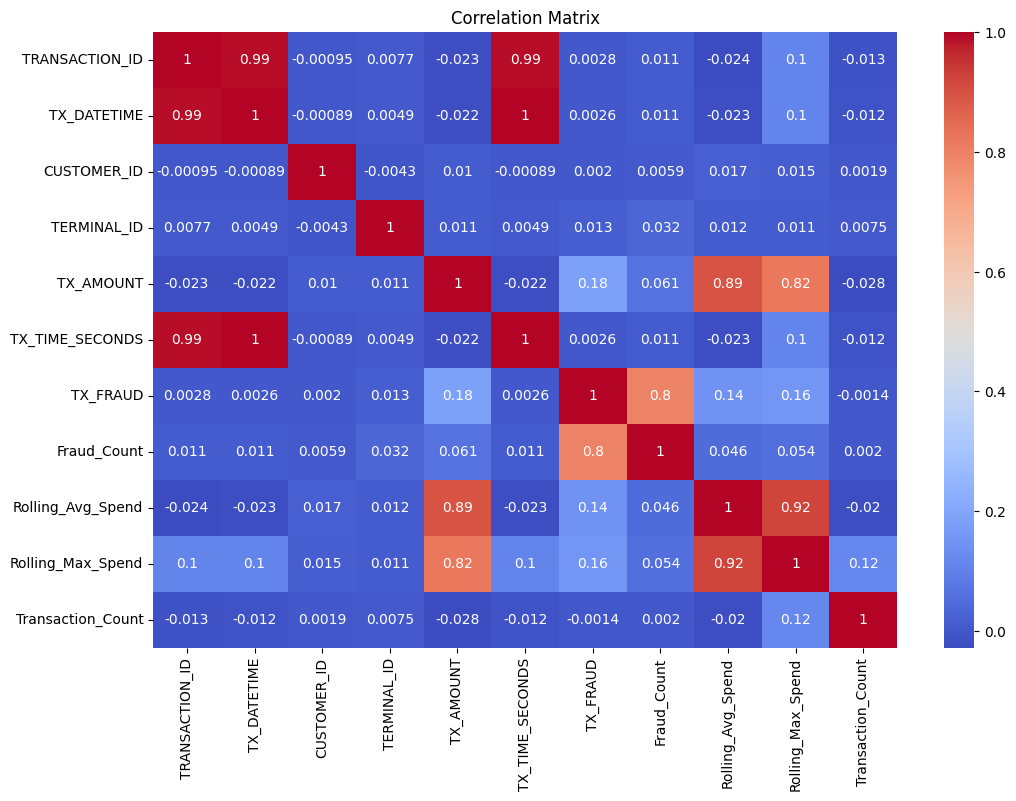

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")


## 2. Fraud vs. Non-Fraud Comparative Analysis

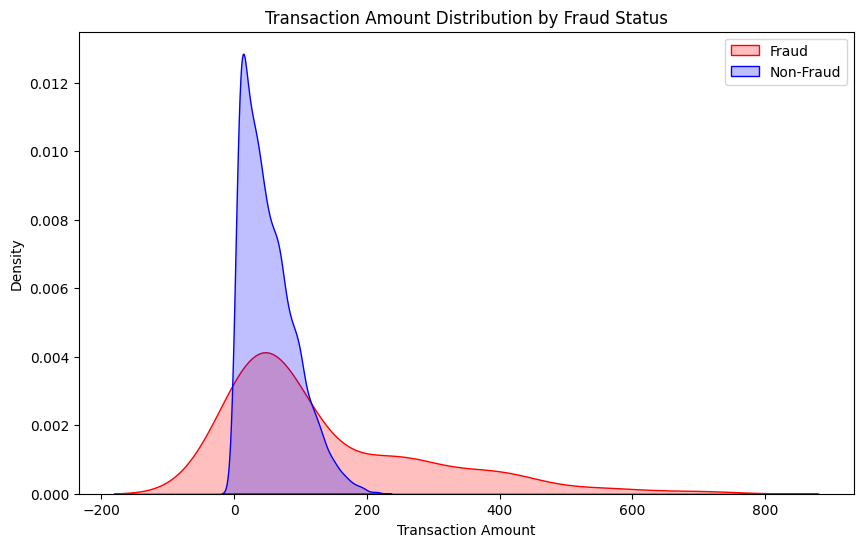

In [24]:
# KDE plot of transaction amount by fraud status
plt.figure(figsize=(10, 6))
sns.kdeplot(df[df['TX_FRAUD'] == 1]['TX_AMOUNT'], label="Fraud", fill=True, color="r")
sns.kdeplot(df[df['TX_FRAUD'] == 0]['TX_AMOUNT'], label="Non-Fraud", fill=True, color="b")
plt.title("Transaction Amount Distribution by Fraud Status")
plt.xlabel("Transaction Amount")
plt.ylabel("Density")
plt.legend()
plt.show()


## 3.Time Based Analysis

<Axes: title={'center': 'Average Fraud Rate by Hour'}, xlabel='TX_HOUR'>

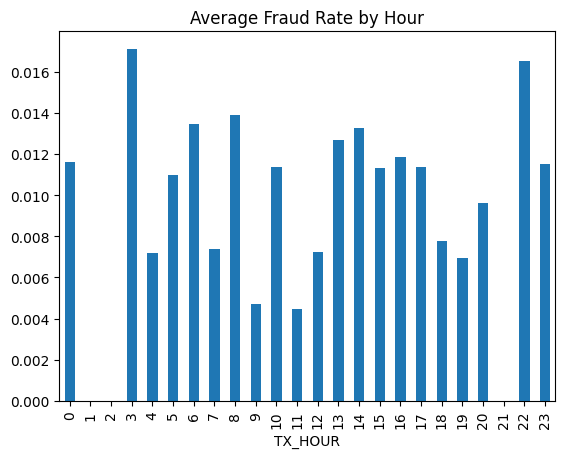

In [25]:
# Extract hour and day of the week
df['TX_HOUR'] = df['TX_TIME_SECONDS'] // 3600 % 24
 

# Hourly fraud analysis
fraud_by_hour = df.groupby('TX_HOUR')['TX_FRAUD'].mean()
fraud_by_hour.plot(kind='bar', title="Average Fraud Rate by Hour")


## 4. Rolling and Aggregated Features

In [26]:
# Aggregating on customer level
customer_agg = df.groupby('CUSTOMER_ID').agg({
    'TX_AMOUNT': ['sum', 'mean', 'max'],
    'TX_FRAUD': 'sum',
    'Fraud_Count': 'sum'
})


In [27]:
customer_agg

TX_AMOUNT                    TX_FRAUD Fraud_Count
                  sum       mean     max      sum         sum
CUSTOMER_ID                                                  
0              519.46  64.932500  112.73        0           0
1              182.62  36.524000   66.79        0           0
2               94.92  94.920000   94.92        0           0
4              301.79  75.447500   94.39        0           0
5              326.85  65.370000   85.05        0           0
...               ...        ...     ...      ...         ...
4993            92.52  46.260000   57.53        0           0
4994           248.14  82.713333   89.28        0           0
4996            35.40  17.700000   18.17        0           0
4998           127.42  63.710000  123.76        0           0
4999           105.64  35.213333   52.18        0           0

[3705 rows x 5 columns]

## 5. Anomaly Detection with Isolation Forest

In [28]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.01)
df['Anomaly_Score'] = iso_forest.fit_predict(df[['TX_AMOUNT', 'Rolling_Avg_Spend', 'Rolling_Max_Spend']])


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9649 entries, 0 to 9648
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TRANSACTION_ID     9649 non-null   int64  
 1   TX_DATETIME        9649 non-null   int64  
 2   CUSTOMER_ID        9649 non-null   Int64  
 3   TERMINAL_ID        9649 non-null   Int64  
 4   TX_AMOUNT          9649 non-null   float64
 5   TX_TIME_SECONDS    9649 non-null   Int64  
 6   TX_FRAUD           9649 non-null   int64  
 7   Fraud_Count        9649 non-null   int64  
 8   Rolling_Avg_Spend  9649 non-null   float64
 9   Rolling_Max_Spend  9649 non-null   float64
 10  Transaction_Count  9649 non-null   int64  
 11  TX_HOUR            9649 non-null   Int64  
 12  Anomaly_Score      9649 non-null   int32  
dtypes: Int64(4), float64(3), int32(1), int64(5)
memory usage: 980.1 KB


In [31]:
df.Anomaly_Score.value_counts()

Anomaly_Score
 1    9552
-1      97
Name: count, dtype: int64

## 6. Visualization of High-Risk Terminals and Customers

<Axes: title={'center': 'Top 10 Terminals by Fraud Rate'}, xlabel='TERMINAL_ID'>

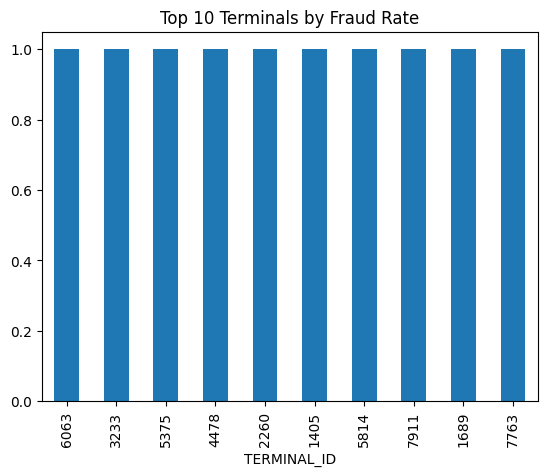

In [32]:
# Terminals with high fraud rate
terminal_fraud = df.groupby('TERMINAL_ID')['TX_FRAUD'].mean().sort_values(ascending=False).head(10)
terminal_fraud.plot(kind='bar', title="Top 10 Terminals by Fraud Rate")


## 7. Cluster Analysis for Behavior Profiles

<Axes: xlabel='TX_AMOUNT', ylabel='Rolling_Avg_Spend'>

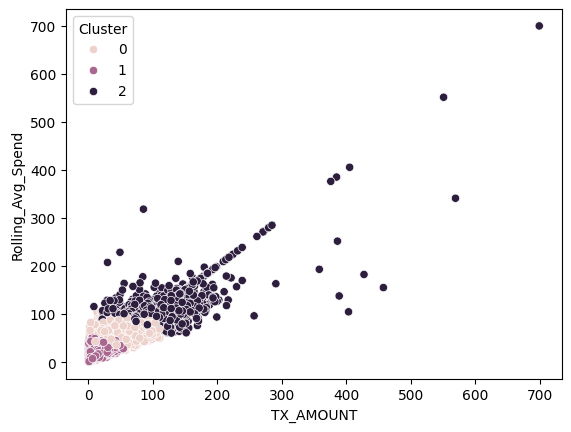

In [33]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
df['Cluster'] = kmeans.fit_predict(df[['TX_AMOUNT', 'Rolling_Avg_Spend', 'Rolling_Max_Spend']])

sns.scatterplot(x='TX_AMOUNT', y='Rolling_Avg_Spend', hue='Cluster', data=df)


## 8. Feature Interactions and Fraud Indicators

<Axes: xlabel='TX_HOUR', ylabel='TX_AMOUNT'>

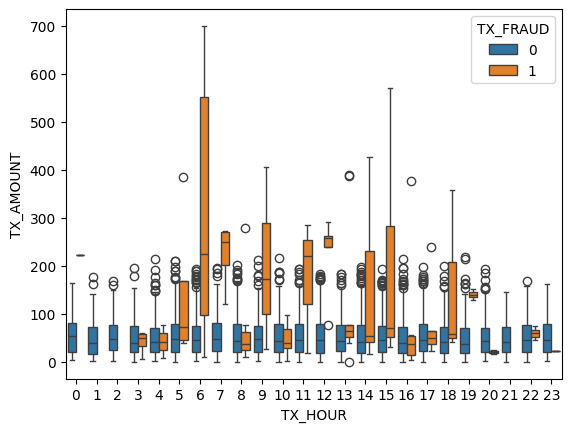

In [34]:
# Interaction plot example
sns.boxplot(x='TX_HOUR', y='TX_AMOUNT', hue='TX_FRAUD', data=df)


## 9. PCA for Dimensionality Reduction and Visualization

Text(0.5, 1.0, 'PCA of Transaction Data')

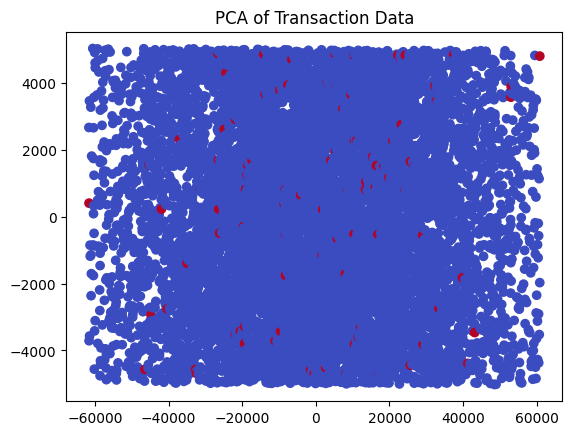

In [35]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_data = pca.fit_transform(df.drop(columns='TX_FRAUD'))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=df['TX_FRAUD'], cmap='coolwarm')
plt.title("PCA of Transaction Data")


## Now let's start modeling 

### Trying various calssification models which is best fit for our data

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier

# List of classifiers to evaluate
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM": SVC(probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Bagging Classifier": BaggingClassifier()
}

# Prepare data
# Assume 'TX_FRAUD' is the target variable and 'df' is your DataFrame
X = df.drop('TX_FRAUD', axis=1)
y = df['TX_FRAUD']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

 

In [37]:
# Dictionary to store metrics for each model
metrics = []

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)  # Train model
    y_pred = model.predict(X_test)  # Predictions on test set
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else np.nan

    # Append results to metrics dictionary
    metrics.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC-ROC": auc
    })

# Create DataFrame to view the results
metrics_df = pd.DataFrame(metrics)
print(metrics_df.sort_values(by="AUC-ROC", ascending=False))


C:\Users\Mohini\miniconda3\envs\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Mohini\miniconda3\envs\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Mohini\miniconda3\envs\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Mohini\miniconda

                 Model  Accuracy  Precision    Recall  F1 Score   AUC-ROC
1        Random Forest  0.997927   0.941176  0.761905  0.842105  0.999254
8   Bagging Classifier  0.997237   0.842105  0.761905  0.800000  0.999254
6    Gradient Boosting  0.997582   0.888889  0.761905  0.820513  0.999238
7             AdaBoost  0.996546   0.761905  0.761905  0.761905  0.999056
5          Naive Bayes  0.987219   0.300000  0.571429  0.393443  0.963250
2        Decision Tree  0.996891   0.750000  0.857143  0.800000  0.927528
4  K-Nearest Neighbors  0.992746   0.000000  0.000000  0.000000  0.500654
3                  SVM  0.992746   0.000000  0.000000  0.000000  0.500000
0  Logistic Regression  0.992746   0.000000  0.000000  0.000000  0.466531


## Visualizations of model performance

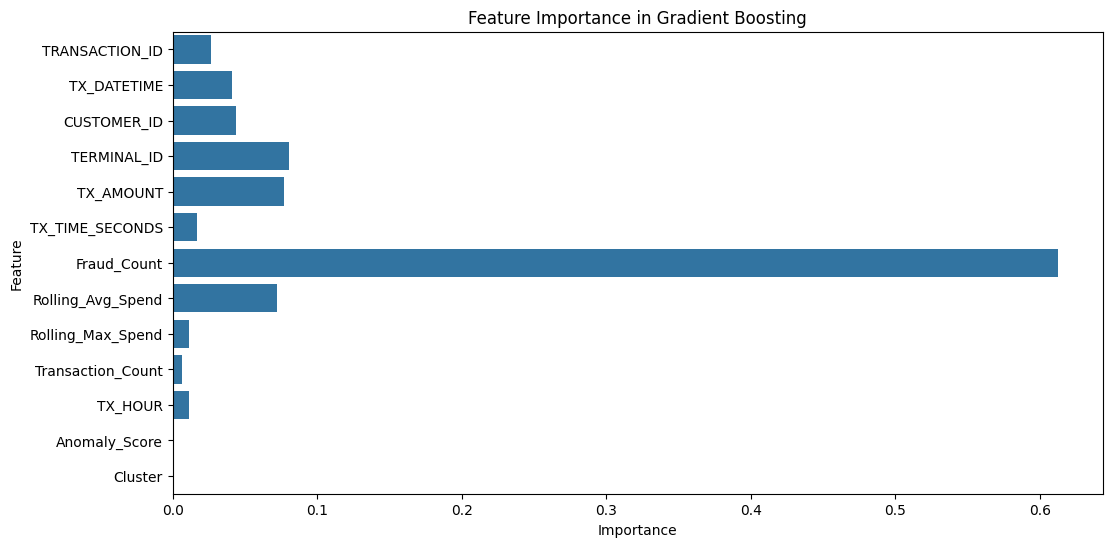

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier

# Train the Gradient Boosting model
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

# Get feature importances
importances = gb_model.feature_importances_
features = X.columns

# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance in Gradient Boosting")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


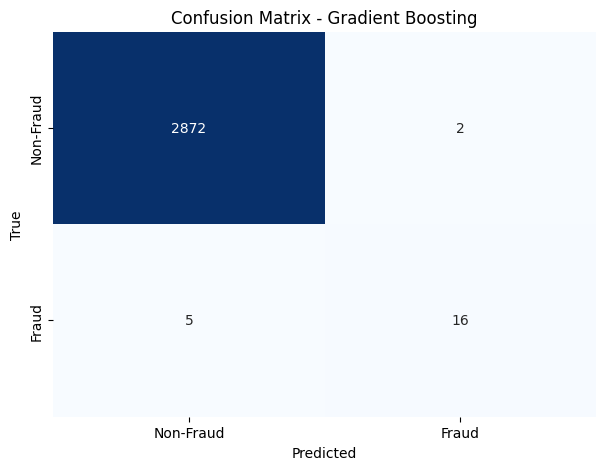

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predictions
y_pred = gb_model.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.title("Confusion Matrix - Gradient Boosting")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


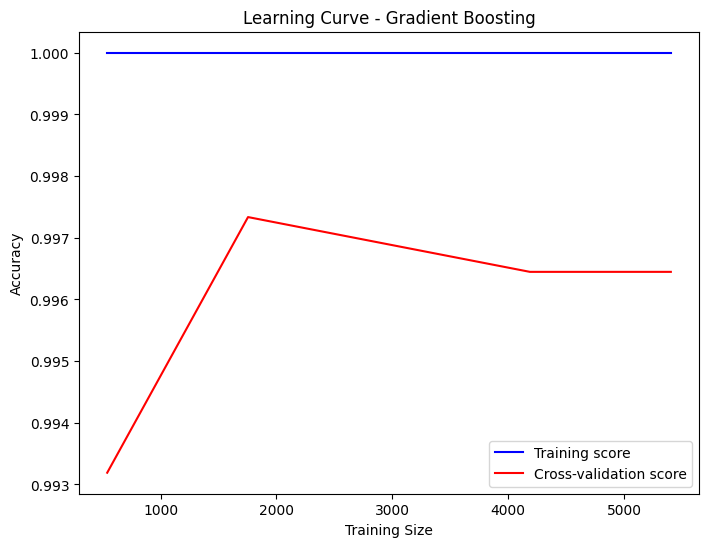

In [40]:
from sklearn.model_selection import learning_curve

# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(gb_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)

# Plot learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label="Training score", color="blue")
plt.plot(train_sizes, np.mean(test_scores, axis=1), label="Cross-validation score", color="red")
plt.title("Learning Curve - Gradient Boosting")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


## Choosing GradientBoostingClassifier and performing hyperparameter tuning using RandomsearchCV

In [41]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import randint
import numpy as np

# Define the Gradient Boosting classifier
gb = GradientBoostingClassifier(random_state=42)

# Define the parameter grid to sample from
param_dist = {
    'n_estimators': randint(50, 300),       # Number of boosting stages
    'learning_rate': [0.01, 0.05, 0.1, 0.2], # Step size for each iteration
    'subsample': [0.7, 0.8, 0.9, 1.0],       # Fraction of samples to use in each boosting iteration
    'max_depth': randint(3, 10),             # Maximum depth of the trees
    'min_samples_split': randint(2, 10),     # Minimum samples required to split a node
    'min_samples_leaf': randint(1, 10),      # Minimum samples required at a leaf node
}

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=gb, param_distributions=param_dist, 
                                   n_iter=100, cv=3, verbose=2, n_jobs=-1, random_state=42)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)



# Get the best parameters and best score
print(f"Best Hyperparameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")


# Get the best model and parameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_

# Evaluate on training data
train_preds = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, train_preds)

# Evaluate on test data
test_preds = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_preds)

# Print the best parameters and accuracy results
print(f"Best Hyperparameters: {best_params}")
print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")

 

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 145, 'subsample': 0.9}
Best Score: 0.9973351097952913
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 145, 'subsample': 0.9}
Training Accuracy: 1.0
Testing Accuracy: 0.9979274611398964


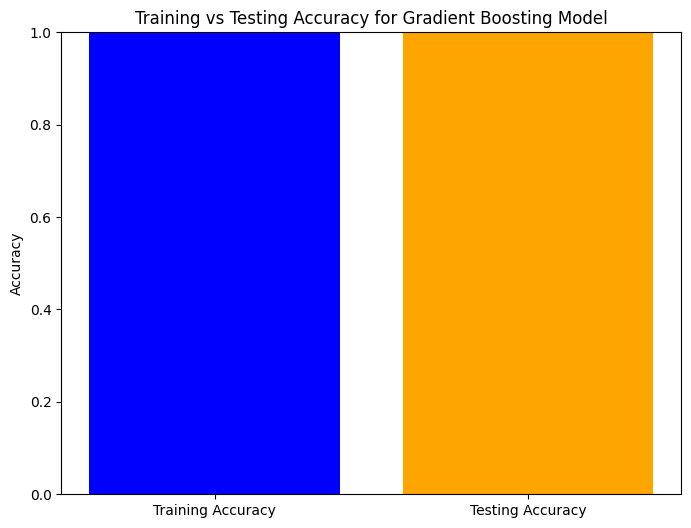

In [42]:
# Plot the graph between training and testing accuracy
plt.figure(figsize=(8, 6))
plt.bar(["Training Accuracy", "Testing Accuracy"], [train_accuracy, test_accuracy], color=['blue', 'orange'])
plt.title("Training vs Testing Accuracy for Gradient Boosting Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()

In [43]:
# Best model evaluation
best_model = random_search.best_estimator_

# Evaluate on the test set
y_pred = best_model.predict(X_test)

# Accuracy, Precision, Recall, F1 Score, ROC AUC can be evaluated
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUC-ROC: {roc_auc}")


Accuracy: 0.9979274611398964
Precision: 0.8947368421052632
Recall: 0.8095238095238095
F1 Score: 0.85
AUC-ROC: 0.9993869503264075


 ## Here we are testing our model

In [44]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Example: Using previously trained Gradient Boosting model (best model from RandomizedSearchCV)

# Sample feature values for prediction (manual entry or hypothetical transaction)
TX_AMOUNT = 150.0
TX_TIME_SECONDS = 3600  # 1 hour in seconds
TX_TIME_DAYS = 2        # 2 days
Fraud_Count = 1
Rolling_Avg_Spend = 250.0
Rolling_Max_Spend = 300.0

# Combine all features into a single 2D array
user_input = np.array([[TX_AMOUNT, TX_TIME_SECONDS, TX_TIME_DAYS, Fraud_Count, Rolling_Avg_Spend, Rolling_Max_Spend]])

# Let's assume the RandomizedSearchCV or a trained Gradient Boosting model is already available
# You can either load your trained model or use the one from RandomizedSearchCV
# For now, I will simulate it with a mock-up, since you would have already trained your model

# Sample code to simulate training and prediction if you don't have a model ready:
param_dist = {
    'n_estimators': randint(50, 300),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
}

# Mock Gradient Boosting model (replace with your trained model)
gb = GradientBoostingClassifier(random_state=42)
# Assuming you've already trained the model with the best parameters from RandomizedSearchCV
# RandomizedSearchCV would return the best model (best_estimator_)
# For this, we will assume `best_model` is the trained GradientBoostingClassifier.

# Instead of fitting on the dataset, we use a mock trained model (replace with actual trained model)
best_model = gb.fit(np.random.rand(100, 6), np.random.randint(0, 2, 100))  # Replace with your actual training

# Now let's predict the outcome using the sample input values
prediction = best_model.predict(user_input)

# Output the result
if prediction == 1:
    print("The transaction is classified as Fraud.")
else:
    print("The transaction is classified as Not Fraud.")


The transaction is classified as Fraud.


## Save the model

In [46]:
import pickle

# Assuming you have a trained model, e.g., `model`
model = best_model  # Replace with your actual trained model

# Save the model to a .pkl file
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Model saved successfully!")


Model saved successfully!


## Load the model

In [47]:
# Load the model from the .pkl file
with open('model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Test the loaded model
prediction = loaded_model.predict(user_input)
print("Prediction:", prediction)


Prediction: [1]
